In [46]:
# 📦 Imports and Configuration

import os
import json
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [47]:
# 📁 src/data/load_dataset.py
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [48]:
# 📁 src/models/mlp_model.py
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [49]:
# 📁 src/metrics/regression_metrics.py
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [50]:
# 📁 src/tuning/train_mlp_function.py
# ➤ Train MLP model with specified hyperparameters and seed
# ➤ Includes data loading, train-test split, early stopping, and evaluation
# ➤ Returns run_id and evaluation metrics on hold-out set


def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam", seed=None):
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔀 Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    # 📊 Plot distribution of target in train and test
    plt.figure(figsize=(8, 4))
    plt.hist(y_train.values, bins=30, alpha=0.6, label="Train", color='blue')
    plt.hist(y_test.values, bins=30, alpha=0.6, label="Test", color='orange')
    plt.title(f"🎯 Target Distribution (seed={seed})")
    plt.xlabel("Mean target value")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 🧪 Проверка на пересечение train и test
    intersection = set(X_train.index).intersection(set(X_test.index))
    if intersection:
        print(f"⚠️ Warning: Found {len(intersection)} overlapping samples in train and test!")
    else:
        print("✅ Train and test are properly separated (no overlap).")



    # Convert to tensors
    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    # ----------------------------
    # Model creation
    # ----------------------------
    model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)
    criterion = nn.MSELoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    early_stopping_patience = 20
    best_loss = float("inf")
    patience_counter = 0
    train_loss_history = []

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()
        train_loss_history.append(current_loss)

        log_interval = max(1, epochs // 10)
        if (epoch + 1) % log_interval == 0 or (epoch + 1) == epochs:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}")

        # Early Stopping
        if current_loss < best_loss:
            best_loss = current_loss
            patience_counter = 0
            best_weights = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

    run_id = f"run_seed_{seed}"

    model.load_state_dict(best_weights)
    weights_registry[run_id] = best_weights


    # ----------------------------
    # Evaluate
    # ----------------------------
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor)
        metrics = evaluate_regression(y_test_tensor, y_pred)

    print(f"\n📊 Metrics:\n{metrics}")
    return run_id, metrics


First model configuration
config_mlp_128h_6e-03lr_ex.json

In [51]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_train.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001"

In [52]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 📌 Path to the config directory and file
config_path = glob.glob(os.path.join(SAVE_ROOT, "config*.json"))[0]

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 128, 'output_dim': 1, 'lr': 0.006, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001
📁 arch_label: mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 10 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


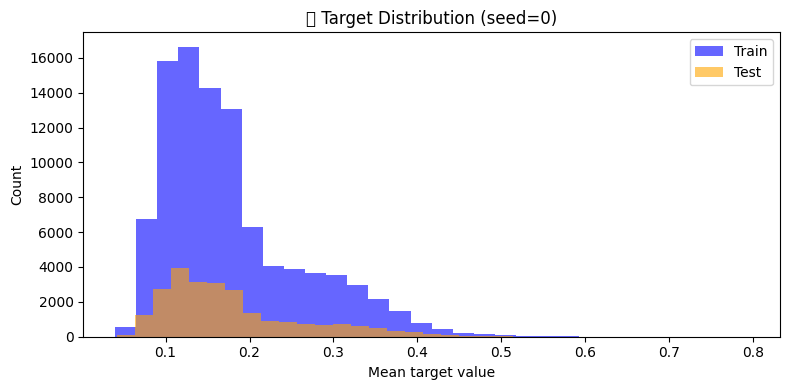

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:06, 14.58it/s]

Epoch [10/100], Loss: 0.3351


Epochs:  22%|██▏       | 22/100 [00:01<00:05, 14.73it/s]

Epoch [20/100], Loss: 0.1655


Epochs:  32%|███▏      | 32/100 [00:02<00:04, 13.77it/s]

Epoch [30/100], Loss: 0.0302


Epochs:  42%|████▏     | 42/100 [00:02<00:04, 14.39it/s]

Epoch [40/100], Loss: 0.0073


Epochs:  52%|█████▏    | 52/100 [00:03<00:03, 14.78it/s]

Epoch [50/100], Loss: 0.0131


Epochs:  62%|██████▏   | 62/100 [00:04<00:02, 13.99it/s]

Epoch [60/100], Loss: 0.0081


Epochs:  72%|███████▏  | 72/100 [00:04<00:01, 14.31it/s]

Epoch [70/100], Loss: 0.0066


Epochs:  82%|████████▏ | 82/100 [00:05<00:01, 14.29it/s]

Epoch [80/100], Loss: 0.0066


Epochs:  92%|█████████▏| 92/100 [00:06<00:00, 13.94it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:06<00:00, 14.37it/s]


Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.0062195430509746075, 'MAE': 0.060817256569862366, 'R2': 0.10123330354690552}

🔁 Run 2 / 10 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


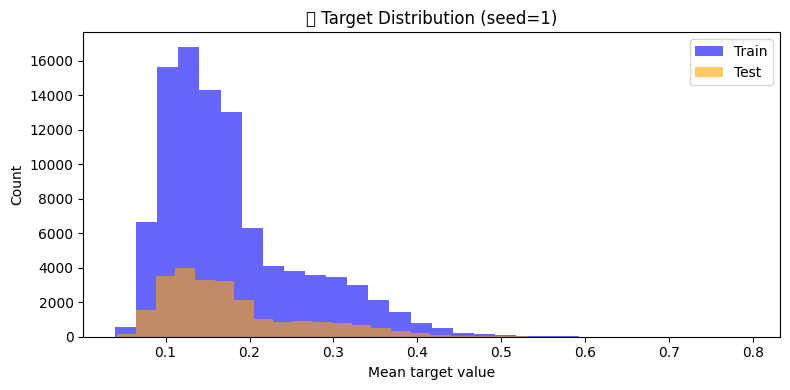

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:06, 13.99it/s]

Epoch [10/100], Loss: 0.5407


Epochs:  22%|██▏       | 22/100 [00:01<00:05, 13.88it/s]

Epoch [20/100], Loss: 0.2638


Epochs:  27%|██▋       | 27/100 [00:02<00:05, 13.44it/s]


⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.10529905557632446, 'MAE': 0.3071765601634979, 'R2': -14.121670722961426}

🔁 Run 3 / 10 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


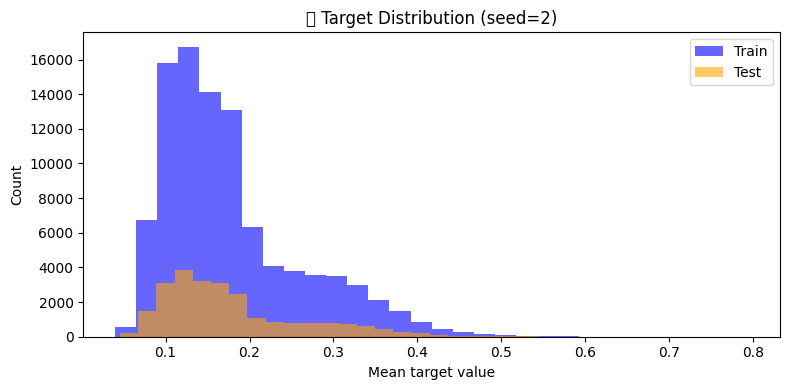

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:06, 13.62it/s]

Epoch [10/100], Loss: 0.4594


Epochs:  22%|██▏       | 22/100 [00:03<00:12,  6.42it/s]

Epoch [20/100], Loss: 0.2117


Epochs:  32%|███▏      | 32/100 [00:04<00:05, 11.49it/s]

Epoch [30/100], Loss: 0.0818


Epochs:  42%|████▏     | 42/100 [00:05<00:04, 12.70it/s]

Epoch [40/100], Loss: 0.0262


Epochs:  52%|█████▏    | 52/100 [00:06<00:03, 12.86it/s]

Epoch [50/100], Loss: 0.0082


Epochs:  62%|██████▏   | 62/100 [00:06<00:03, 11.12it/s]

Epoch [60/100], Loss: 0.0068


Epochs:  72%|███████▏  | 72/100 [00:07<00:02, 10.30it/s]

Epoch [70/100], Loss: 0.0075


Epochs:  82%|████████▏ | 82/100 [00:08<00:01, 10.79it/s]

Epoch [80/100], Loss: 0.0066


Epochs:  91%|█████████ | 91/100 [00:09<00:00,  9.82it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.31it/s]


Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.006251135841012001, 'MAE': 0.0622088722884655, 'R2': 0.1024777889251709}

🔁 Run 4 / 10 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


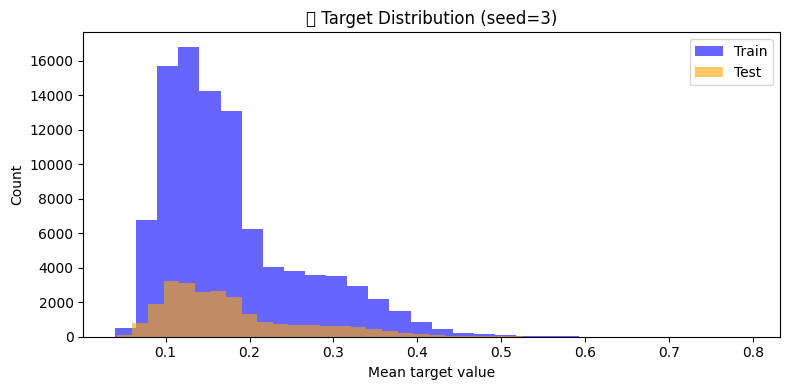

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:01<00:08, 10.70it/s]

Epoch [10/100], Loss: 0.3949


Epochs:  22%|██▏       | 22/100 [00:01<00:07, 11.02it/s]

Epoch [20/100], Loss: 0.1932


Epochs:  31%|███       | 31/100 [00:02<00:07,  9.29it/s]

Epoch [30/100], Loss: 0.0889


Epochs:  42%|████▏     | 42/100 [00:04<00:05, 10.05it/s]

Epoch [40/100], Loss: 0.0383


Epochs:  52%|█████▏    | 52/100 [00:05<00:04, 10.29it/s]

Epoch [50/100], Loss: 0.0138


Epochs:  62%|██████▏   | 62/100 [00:05<00:03, 10.82it/s]

Epoch [60/100], Loss: 0.0067


Epochs:  72%|███████▏  | 72/100 [00:06<00:02, 10.66it/s]

Epoch [70/100], Loss: 0.0069


Epochs:  82%|████████▏ | 82/100 [00:07<00:01, 10.34it/s]

Epoch [80/100], Loss: 0.0069


Epochs:  92%|█████████▏| 92/100 [00:08<00:00, 10.73it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:09<00:00, 10.47it/s]


Epoch [100/100], Loss: 0.0064

📊 Metrics:
{'MSE': 0.006308801472187042, 'MAE': 0.06317921727895737, 'R2': 0.08027803897857666}

🔁 Run 5 / 10 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


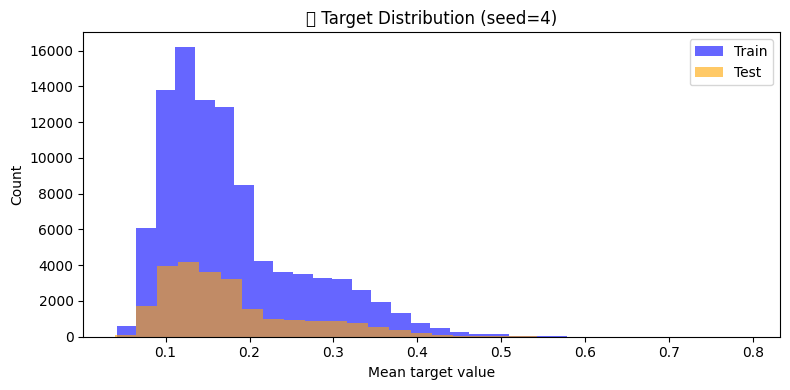

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 10/100 [00:00<00:08, 10.81it/s]

Epoch [10/100], Loss: 0.4290


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.35it/s]

Epoch [20/100], Loss: 0.2039


Epochs:  27%|██▋       | 27/100 [00:02<00:07,  9.59it/s]


⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.08466488122940063, 'MAE': 0.2753371596336365, 'R2': -11.288680076599121}

🔁 Run 6 / 10 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


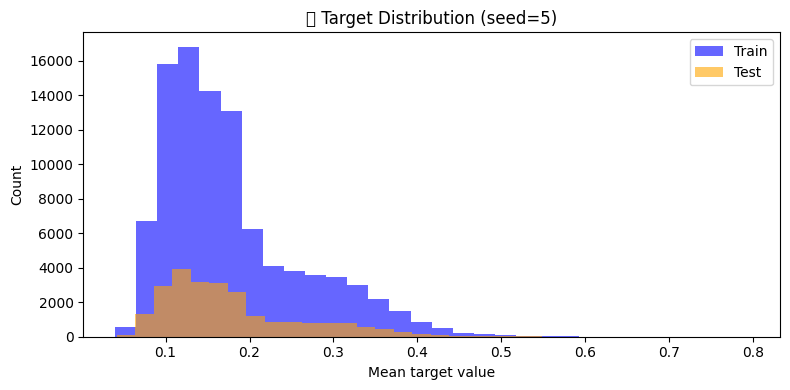

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:01<00:08, 10.10it/s]

Epoch [10/100], Loss: 0.3893


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.70it/s]

Epoch [20/100], Loss: 0.2018


Epochs:  27%|██▋       | 27/100 [00:02<00:07,  9.77it/s]


⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.08322880417108536, 'MAE': 0.2718821167945862, 'R2': -10.919119834899902}

🔁 Run 7 / 10 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


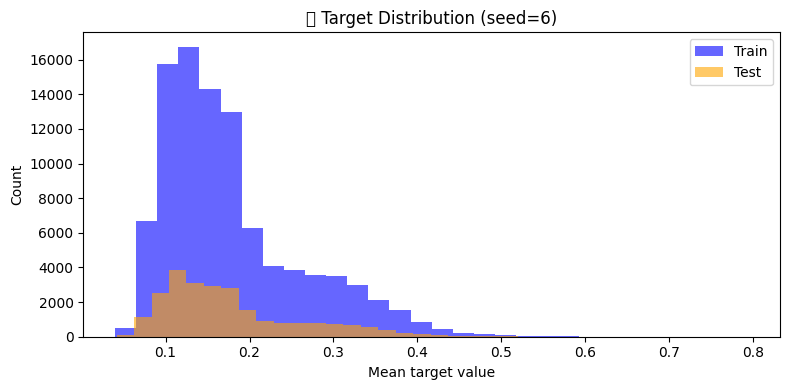

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:10,  8.87it/s]

Epoch [10/100], Loss: 0.3762


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.87it/s]

Epoch [20/100], Loss: 0.1736


Epochs:  27%|██▋       | 27/100 [00:02<00:07,  9.33it/s]

⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.06349864602088928, 'MAE': 0.2349836230278015, 'R2': -8.21435546875}

🔁 Run 8 / 10 (seed = 7)
Dataset loaded: 121113 rows, 15 columns



/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


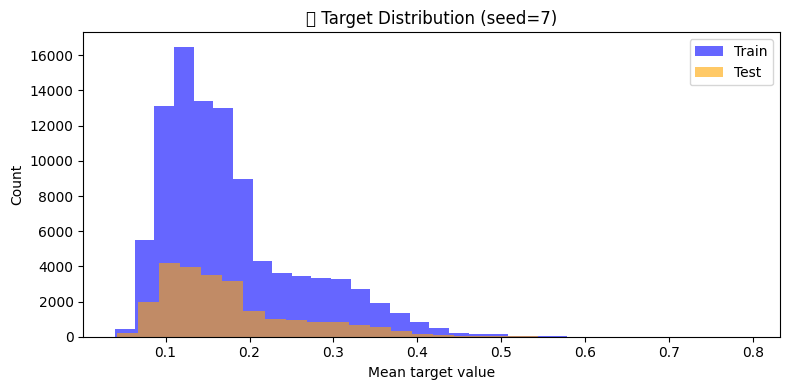

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 10/100 [00:00<00:08, 10.19it/s]

Epoch [10/100], Loss: 0.4092


Epochs:  21%|██        | 21/100 [00:02<00:07,  9.89it/s]

Epoch [20/100], Loss: 0.1626


Epochs:  31%|███       | 31/100 [00:03<00:07,  9.82it/s]

Epoch [30/100], Loss: 0.0300


Epochs:  41%|████      | 41/100 [00:04<00:06,  8.49it/s]

Epoch [40/100], Loss: 0.0069


Epochs:  51%|█████     | 51/100 [00:07<00:08,  5.80it/s]

Epoch [50/100], Loss: 0.0119


Epochs:  61%|██████    | 61/100 [00:09<00:04,  9.20it/s]

Epoch [60/100], Loss: 0.0086


Epochs:  70%|███████   | 70/100 [00:10<00:03,  9.14it/s]

Epoch [70/100], Loss: 0.0065


Epochs:  81%|████████  | 81/100 [00:11<00:02,  9.32it/s]

Epoch [80/100], Loss: 0.0067


Epochs:  91%|█████████ | 91/100 [00:12<00:00,  9.58it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:13<00:00,  7.53it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006180064752697945, 'MAE': 0.05979088693857193, 'R2': 0.09952586889266968}

🔁 Run 9 / 10 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


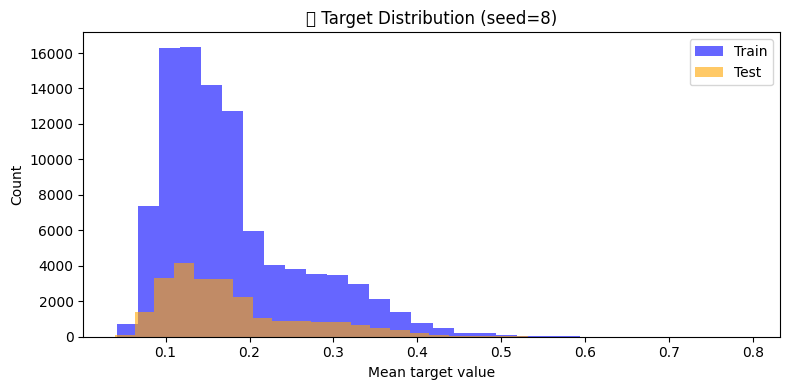

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  8.99it/s]

Epoch [10/100], Loss: 0.4303


Epochs:  20%|██        | 20/100 [00:02<00:08,  9.09it/s]

Epoch [20/100], Loss: 0.1666


Epochs:  31%|███       | 31/100 [00:03<00:07,  9.55it/s]

Epoch [30/100], Loss: 0.0278


Epochs:  41%|████      | 41/100 [00:04<00:07,  8.15it/s]

Epoch [40/100], Loss: 0.0069


Epochs:  51%|█████     | 51/100 [00:05<00:05,  8.53it/s]

Epoch [50/100], Loss: 0.0126


Epochs:  61%|██████    | 61/100 [00:06<00:04,  8.80it/s]

Epoch [60/100], Loss: 0.0083


Epochs:  71%|███████   | 71/100 [00:07<00:03,  9.58it/s]

Epoch [70/100], Loss: 0.0064


Epochs:  81%|████████  | 81/100 [00:09<00:02,  8.98it/s]

Epoch [80/100], Loss: 0.0066


Epochs:  91%|█████████ | 91/100 [00:10<00:01,  6.82it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:11<00:00,  8.57it/s]


Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.006287452764809132, 'MAE': 0.061686623841524124, 'R2': 0.0997246503829956}

🔁 Run 10 / 10 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


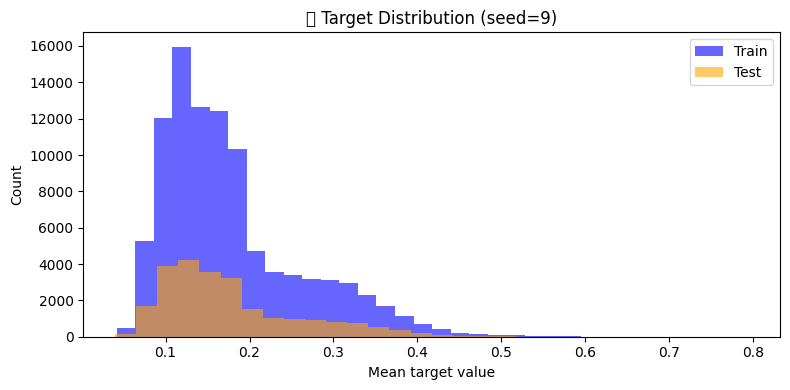

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:12,  7.32it/s]

Epoch [10/100], Loss: 0.3451


Epochs:  21%|██        | 21/100 [00:02<00:10,  7.88it/s]

Epoch [20/100], Loss: 0.1697


Epochs:  31%|███       | 31/100 [00:03<00:07,  8.64it/s]

Epoch [30/100], Loss: 0.0359


Epochs:  41%|████      | 41/100 [00:05<00:07,  7.99it/s]

Epoch [40/100], Loss: 0.0066


Epochs:  51%|█████     | 51/100 [00:06<00:06,  7.97it/s]

Epoch [50/100], Loss: 0.0102


Epochs:  61%|██████    | 61/100 [00:07<00:04,  9.31it/s]

Epoch [60/100], Loss: 0.0089


Epochs:  71%|███████   | 71/100 [00:08<00:03,  9.14it/s]

Epoch [70/100], Loss: 0.0063


Epochs:  81%|████████  | 81/100 [00:09<00:02,  9.21it/s]

Epoch [80/100], Loss: 0.0065


Epochs:  91%|█████████ | 91/100 [00:10<00:01,  8.60it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:11<00:00,  8.34it/s]


Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.0061507378704845905, 'MAE': 0.06108182668685913, 'R2': 0.11073946952819824}
📁 Best weights saved to: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001/best_model_weights_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_9 with R2 = 0.1107
   R2   = 0.1107
   MAE  = 0.0611
   MSE  = 0.006151


In [53]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 10  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best run's metrics
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


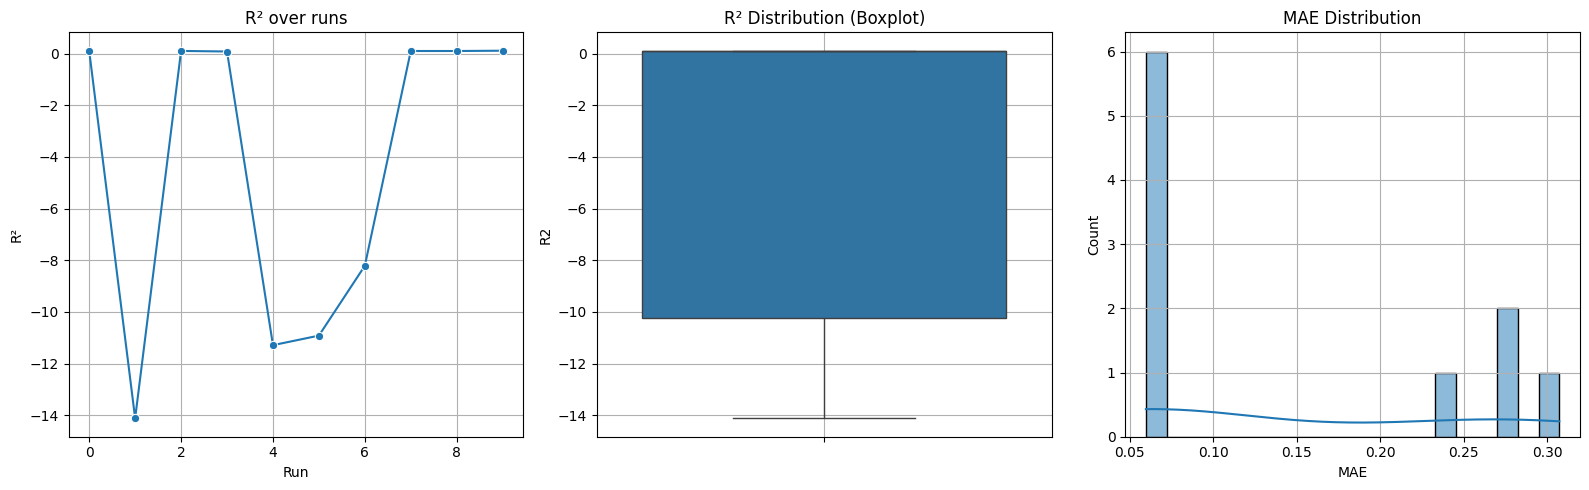

📈 Stability analysis complete:
{
    "R2_mean": -4.395,
    "R2_std": 5.9671,
    "MAE_mean": 0.1458,
    "MAE_std": 0.1102,
    "MSE_mean": 0.037409,
    "MSE_std": 0.041438,
    "runs": 10
}
📁 Saved metrics: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001/stability_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_001/stability_plot_mlp_128h_6e-03lr_16bs_10000ep_Tanh_Adam.png


In [54]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")


Second model configuration
config_mlp_64h_8e-03lr_ex.json

In [55]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_train.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_002"

In [56]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 📌 Path to the config directory and file
config_path = glob.glob(os.path.join(SAVE_ROOT, "config*.json"))[0]

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 64, 'output_dim': 1, 'lr': 0.008, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_002
📁 arch_label: mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 10 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


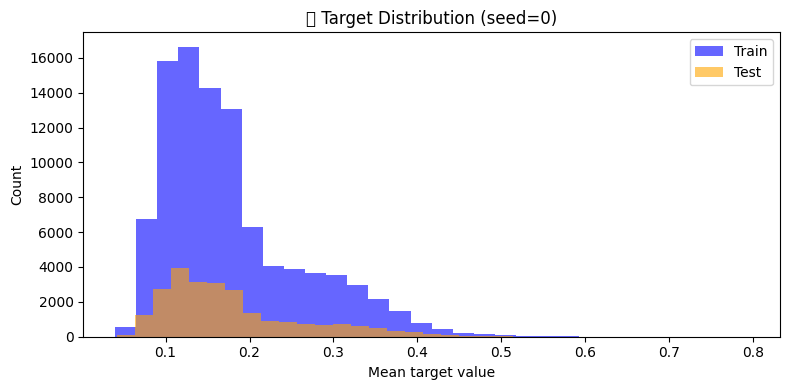

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 23.63it/s]

Epoch [10/100], Loss: 0.1557


Epochs:  21%|██        | 21/100 [00:00<00:03, 20.63it/s]

Epoch [20/100], Loss: 0.0319


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 20.66it/s]

Epoch [30/100], Loss: 0.0071


Epochs:  41%|████      | 41/100 [00:01<00:03, 19.05it/s]

Epoch [40/100], Loss: 0.0108


Epochs:  53%|█████▎    | 53/100 [00:02<00:02, 20.60it/s]

Epoch [50/100], Loss: 0.0080


Epochs:  62%|██████▏   | 62/100 [00:03<00:01, 20.63it/s]

Epoch [60/100], Loss: 0.0063


Epochs:  74%|███████▍  | 74/100 [00:03<00:01, 20.34it/s]

Epoch [70/100], Loss: 0.0064


Epochs:  83%|████████▎ | 83/100 [00:03<00:00, 21.88it/s]

Epoch [80/100], Loss: 0.0061


Epochs:  92%|█████████▏| 92/100 [00:04<00:00, 21.08it/s]

Epoch [90/100], Loss: 0.0061


Epochs: 100%|██████████| 100/100 [00:04<00:00, 20.78it/s]


Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.006050573196262121, 'MAE': 0.05963105335831642, 'R2': 0.1256505846977234}

🔁 Run 2 / 10 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


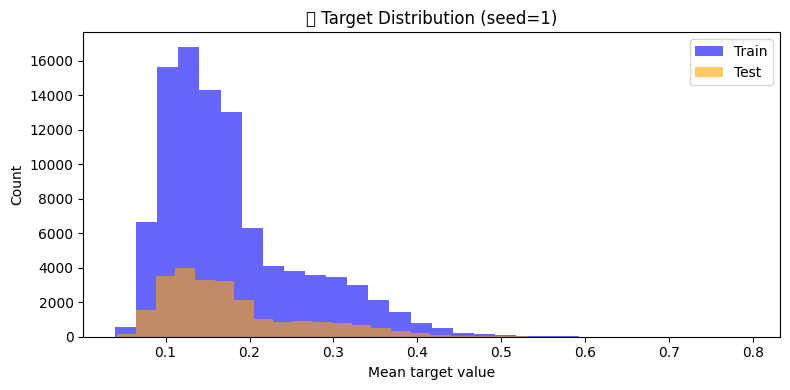

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:04, 20.96it/s]

Epoch [10/100], Loss: 0.1597


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 20.08it/s]

Epoch [20/100], Loss: 0.0649


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 20.10it/s]

Epoch [30/100], Loss: 0.0224


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 22.61it/s]

Epoch [40/100], Loss: 0.0107


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 22.15it/s]

Epoch [50/100], Loss: 0.0072


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 20.64it/s]

Epoch [60/100], Loss: 0.0064


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 20.17it/s]

Epoch [70/100], Loss: 0.0063


Epochs:  84%|████████▍ | 84/100 [00:03<00:00, 22.45it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 22.08it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.28it/s]


Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006116101052612066, 'MAE': 0.05999932438135147, 'R2': 0.1216856837272644}

🔁 Run 3 / 10 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


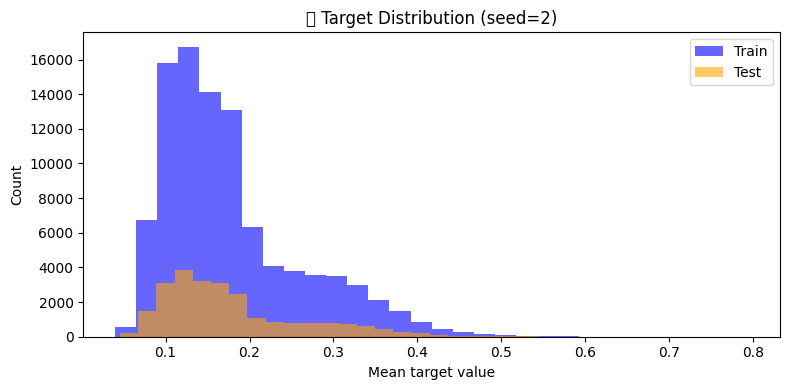

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 23.79it/s]

Epoch [10/100], Loss: 0.0986


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 22.73it/s]

Epoch [20/100], Loss: 0.0221


Epochs:  33%|███▎      | 33/100 [00:01<00:02, 23.82it/s]

Epoch [30/100], Loss: 0.0081


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 21.55it/s]

Epoch [40/100], Loss: 0.0107


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 20.98it/s]

Epoch [50/100], Loss: 0.0067


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 22.58it/s]

Epoch [60/100], Loss: 0.0065


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 20.80it/s]

Epoch [70/100], Loss: 0.0062


Epochs:  82%|████████▏ | 82/100 [00:03<00:00, 18.32it/s]

Epoch [80/100], Loss: 0.0061


Epochs:  94%|█████████▍| 94/100 [00:04<00:00, 20.82it/s]

Epoch [90/100], Loss: 0.0060


Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.63it/s]


Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.006047132425010204, 'MAE': 0.0599946491420269, 'R2': 0.1317681074142456}

🔁 Run 4 / 10 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


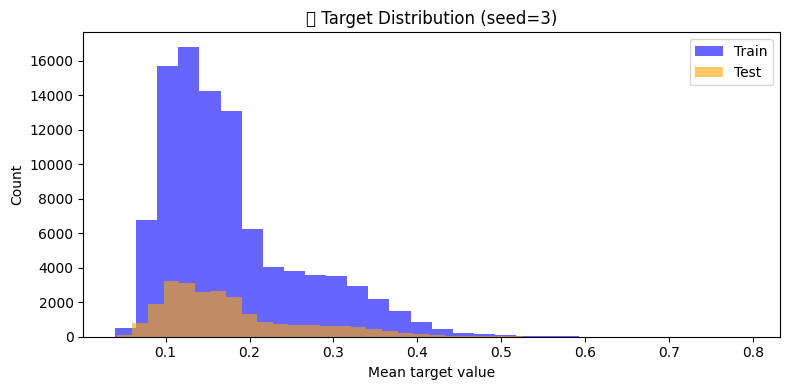

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:02, 30.87it/s]

Epoch [10/100], Loss: 0.1791


Epochs:  22%|██▏       | 22/100 [00:00<00:03, 25.79it/s]

Epoch [20/100], Loss: 0.0894


Epochs:  34%|███▍      | 34/100 [00:01<00:02, 22.21it/s]

Epoch [30/100], Loss: 0.0240


Epochs:  43%|████▎     | 43/100 [00:01<00:02, 23.52it/s]

Epoch [40/100], Loss: 0.0080


Epochs:  52%|█████▏    | 52/100 [00:02<00:01, 24.00it/s]

Epoch [50/100], Loss: 0.0067


Epochs:  61%|██████    | 61/100 [00:02<00:01, 23.21it/s]

Epoch [60/100], Loss: 0.0073


Epochs:  73%|███████▎  | 73/100 [00:03<00:01, 22.57it/s]

Epoch [70/100], Loss: 0.0067


Epochs:  85%|████████▌ | 85/100 [00:03<00:00, 23.92it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  94%|█████████▍| 94/100 [00:03<00:00, 24.91it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:04<00:00, 24.05it/s]


Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006075087934732437, 'MAE': 0.05995842069387436, 'R2': 0.11434972286224365}

🔁 Run 5 / 10 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


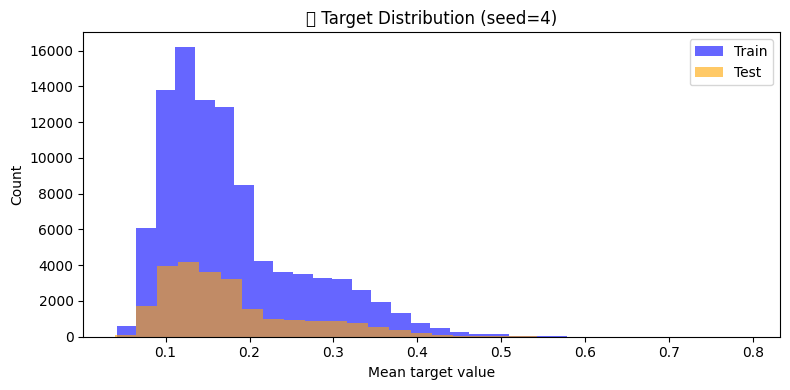

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 23.32it/s]

Epoch [10/100], Loss: 0.1392


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 21.50it/s]

Epoch [20/100], Loss: 0.0170


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 21.75it/s]

Epoch [30/100], Loss: 0.0101


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 21.52it/s]

Epoch [40/100], Loss: 0.0116


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 22.22it/s]

Epoch [50/100], Loss: 0.0068


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 21.61it/s]

Epoch [60/100], Loss: 0.0066


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 21.86it/s]

Epoch [70/100], Loss: 0.0064


Epochs:  84%|████████▍ | 84/100 [00:03<00:00, 22.34it/s]

Epoch [80/100], Loss: 0.0062


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 22.48it/s]

Epoch [90/100], Loss: 0.0061


Epochs: 100%|██████████| 100/100 [00:04<00:00, 22.15it/s]


Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.005924695637077093, 'MAE': 0.058441609144210815, 'R2': 0.14006030559539795}

🔁 Run 6 / 10 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


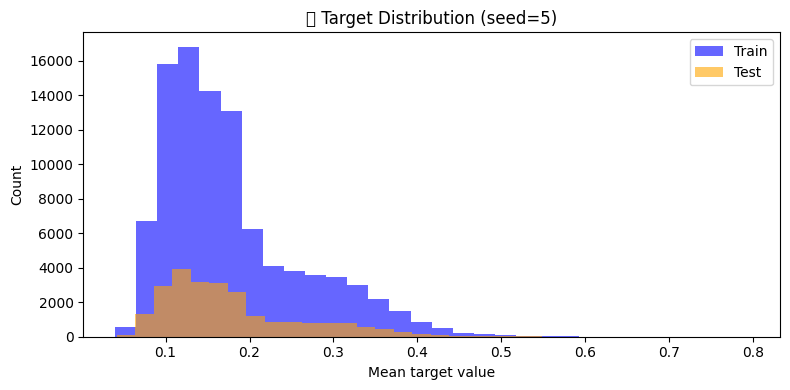

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 23.44it/s]

Epoch [10/100], Loss: 0.1114


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 22.38it/s]

Epoch [20/100], Loss: 0.0386


Epochs:  33%|███▎      | 33/100 [00:01<00:02, 22.44it/s]

Epoch [30/100], Loss: 0.0079


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 20.08it/s]

Epoch [40/100], Loss: 0.0080


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 21.52it/s]

Epoch [50/100], Loss: 0.0083


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 20.03it/s]

Epoch [60/100], Loss: 0.0066


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 20.39it/s]

Epoch [70/100], Loss: 0.0065


Epochs:  84%|████████▍ | 84/100 [00:03<00:00, 21.10it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 22.11it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.69it/s]


Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.006205872166901827, 'MAE': 0.06026510149240494, 'R2': 0.11126279830932617}

🔁 Run 7 / 10 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


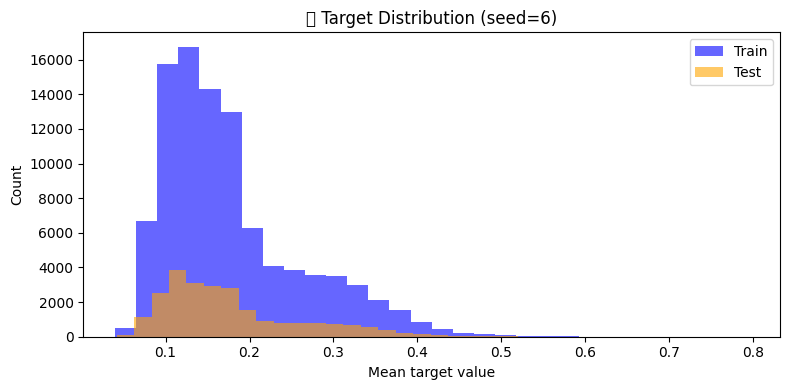

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:03, 25.04it/s]

Epoch [10/100], Loss: 0.1764


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 21.93it/s]

Epoch [20/100], Loss: 0.0167


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 19.45it/s]

Epoch [30/100], Loss: 0.0133


Epochs:  42%|████▏     | 42/100 [00:04<00:16,  3.44it/s]

Epoch [40/100], Loss: 0.0122


Epochs:  54%|█████▍    | 54/100 [00:04<00:04,  9.45it/s]

Epoch [50/100], Loss: 0.0064


Epochs:  63%|██████▎   | 63/100 [00:05<00:02, 14.39it/s]

Epoch [60/100], Loss: 0.0070


Epochs:  72%|███████▏  | 72/100 [00:05<00:01, 17.95it/s]

Epoch [70/100], Loss: 0.0062


Epochs:  84%|████████▍ | 84/100 [00:06<00:00, 20.34it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  93%|█████████▎| 93/100 [00:06<00:00, 17.55it/s]

Epoch [90/100], Loss: 0.0061


Epochs: 100%|██████████| 100/100 [00:07<00:00, 13.66it/s]


Epoch [100/100], Loss: 0.0060

📊 Metrics:
{'MSE': 0.006024628411978483, 'MAE': 0.05894527956843376, 'R2': 0.12575984001159668}

🔁 Run 8 / 10 (seed = 7)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


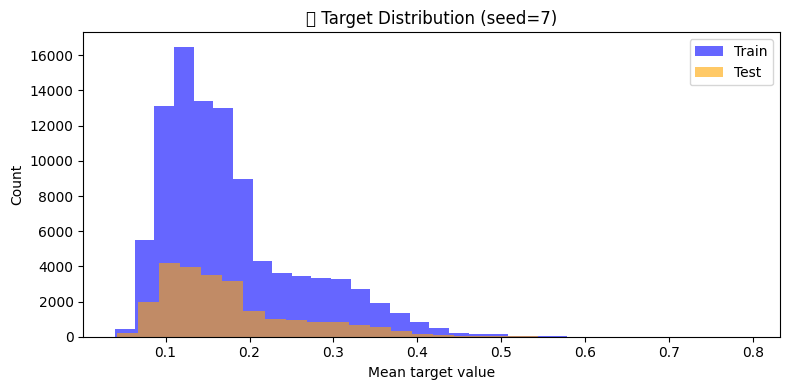

✅ Train and test are properly separated (no overlap).


Epochs:  13%|█▎        | 13/100 [00:00<00:04, 19.07it/s]

Epoch [10/100], Loss: 0.0882


Epochs:  22%|██▏       | 22/100 [00:01<00:04, 16.13it/s]

Epoch [20/100], Loss: 0.0592


Epochs:  32%|███▏      | 32/100 [00:01<00:03, 17.35it/s]

Epoch [30/100], Loss: 0.0127


Epochs:  42%|████▏     | 42/100 [00:02<00:03, 16.42it/s]

Epoch [40/100], Loss: 0.0066


Epochs:  52%|█████▏    | 52/100 [00:03<00:02, 16.22it/s]

Epoch [50/100], Loss: 0.0080


Epochs:  62%|██████▏   | 62/100 [00:03<00:02, 15.91it/s]

Epoch [60/100], Loss: 0.0071


Epochs:  72%|███████▏  | 72/100 [00:04<00:01, 17.57it/s]

Epoch [70/100], Loss: 0.0063


Epochs:  82%|████████▏ | 82/100 [00:04<00:01, 14.80it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  94%|█████████▍| 94/100 [00:05<00:00, 19.33it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:05<00:00, 16.94it/s]


Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006040771026164293, 'MAE': 0.06083013117313385, 'R2': 0.11982184648513794}

🔁 Run 9 / 10 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


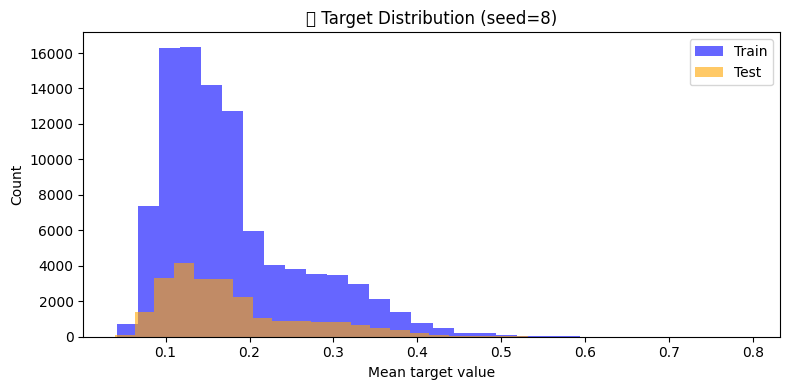

✅ Train and test are properly separated (no overlap).


Epochs:  12%|█▏        | 12/100 [00:00<00:04, 20.42it/s]

Epoch [10/100], Loss: 0.2059


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 21.27it/s]

Epoch [20/100], Loss: 0.0781


Epochs:  33%|███▎      | 33/100 [00:01<00:03, 20.51it/s]

Epoch [30/100], Loss: 0.0201


Epochs:  42%|████▏     | 42/100 [00:02<00:02, 20.85it/s]

Epoch [40/100], Loss: 0.0075


Epochs:  54%|█████▍    | 54/100 [00:02<00:02, 21.27it/s]

Epoch [50/100], Loss: 0.0069


Epochs:  63%|██████▎   | 63/100 [00:02<00:01, 21.81it/s]

Epoch [60/100], Loss: 0.0074


Epochs:  72%|███████▏  | 72/100 [00:03<00:01, 22.41it/s]

Epoch [70/100], Loss: 0.0067


Epochs:  84%|████████▍ | 84/100 [00:03<00:00, 22.28it/s]

Epoch [80/100], Loss: 0.0064


Epochs:  93%|█████████▎| 93/100 [00:04<00:00, 22.42it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:04<00:00, 21.52it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.0063724881038069725, 'MAE': 0.06125267967581749, 'R2': 0.08754879236221313}

🔁 Run 10 / 10 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


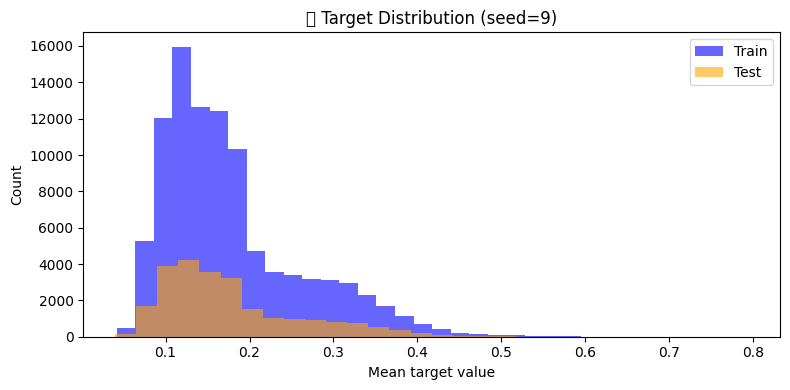

✅ Train and test are properly separated (no overlap).


Epochs:  15%|█▌        | 15/100 [00:00<00:03, 24.17it/s]

Epoch [10/100], Loss: 0.1262


Epochs:  24%|██▍       | 24/100 [00:01<00:03, 23.86it/s]

Epoch [20/100], Loss: 0.0432


Epochs:  33%|███▎      | 33/100 [00:01<00:02, 23.92it/s]

Epoch [30/100], Loss: 0.0109


Epochs:  42%|████▏     | 42/100 [00:01<00:02, 23.59it/s]

Epoch [40/100], Loss: 0.0070
⏹️ Early stopping at epoch 43

📊 Metrics:
{'MSE': 0.009978394024074078, 'MAE': 0.08696670085191727, 'R2': -0.4426548480987549}
📁 Best weights saved to: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_002/best_model_weights_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_4 with R2 = 0.1401
   R2   = 0.1401
   MAE  = 0.0584
   MSE  = 0.005925


In [57]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 10  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best run's metrics
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


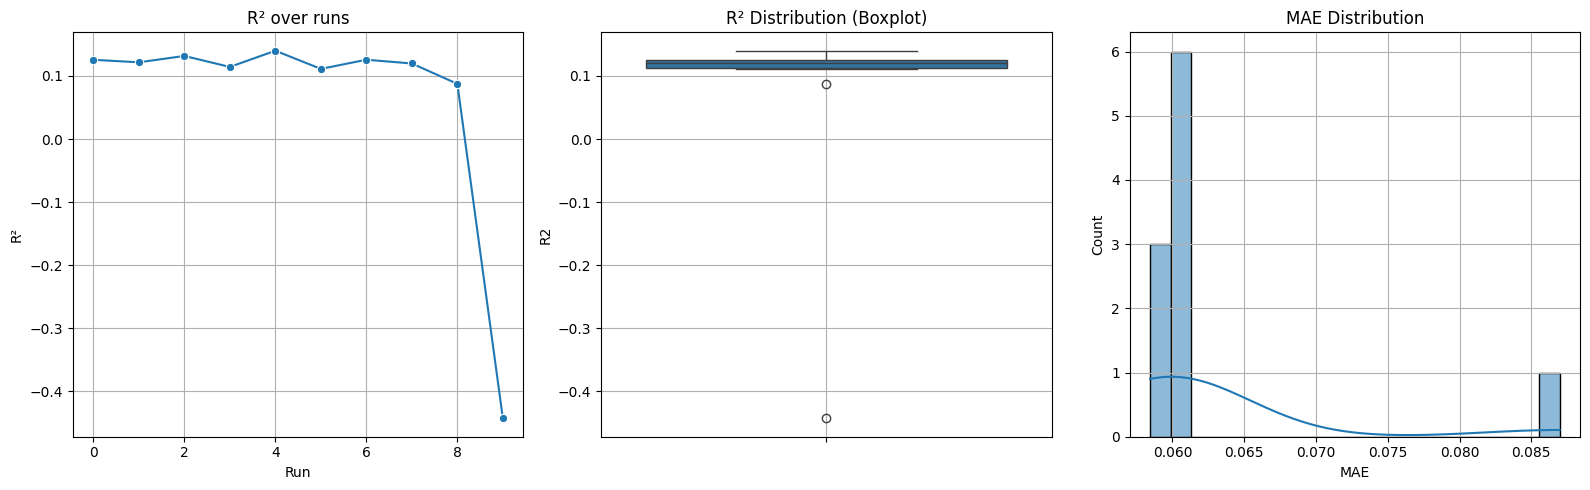

📈 Stability analysis complete:
{
    "R2_mean": 0.0635,
    "R2_std": 0.1784,
    "MAE_mean": 0.0626,
    "MAE_std": 0.0086,
    "MSE_mean": 0.006484,
    "MSE_std": 0.001234,
    "runs": 10
}
📁 Saved metrics: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_002/stability_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_002/stability_plot_mlp_64h_8e-03lr_16bs_10000ep_Tanh_Adam.png


In [58]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")


Third model configuration
config_mlp_128h_4e-03lr_ex.json

In [59]:
# 📁 src/tuning/setup_paths.py
# ➤ Paths for hyperparameter search: tuning runs, logs, results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#DATA_PATH = "/kaggle/input/wind-pressure-prediction-2025/windloading_train.csv"
#SAVE_ROOT = "/kaggle/working"

DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_003"

In [60]:
# 📁 src/tuning/load_config.py
# ➤ Load best configuration from saved JSON, convert activation string to function,
# ➤ build readable architecture label for logging and saving results

# 📌 Path to the config directory and file
config_path = glob.glob(os.path.join(SAVE_ROOT, "config*.json"))[0]

# 🔁 Mapping string from config.json to actual PyTorch activation function
activation_map = {
    "ReLU": torch.nn.ReLU,
    "Tanh": torch.nn.Tanh,
    "LeakyReLU": torch.nn.LeakyReLU
}

# 📦 Load and decode configuration
with open(config_path, "r") as f:
    config = json.load(f)

# 🔧 Convert activation function string to callable object
config["activation_fn"] = activation_map[config["activation_fn"]]

# 🏷 Extract config name from path
config_name = os.path.basename(os.path.dirname(config_path))  # → 'config_001'

# 🧠 Build architecture label
arch_label = (
    f"mlp_{config['hidden_dim']}h_"
    f"{config['lr']:.0e}lr_"
    f"{config['batch_size']}bs_"
    f"{config['epochs']}ep_"
    f"{config['activation_fn'].__name__}_"
    f"{config['optimizer_name']}"
)

print("✅ Loaded config:")
print(config)
print(f"📂 SAVE_ROOT: {SAVE_ROOT}")
print(f"📁 arch_label: {arch_label}")

✅ Loaded config:
{'input_dim': 5, 'hidden_dim': 128, 'output_dim': 1, 'lr': 0.004, 'epochs': 10000, 'batch_size': 16, 'activation_fn': <class 'torch.nn.modules.activation.Tanh'>, 'optimizer_name': 'Adam', 'features': ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'], 'targets': ['StdDev']}
📂 SAVE_ROOT: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_003
📁 arch_label: mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam



🔁 Run 1 / 10 (seed = 0)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


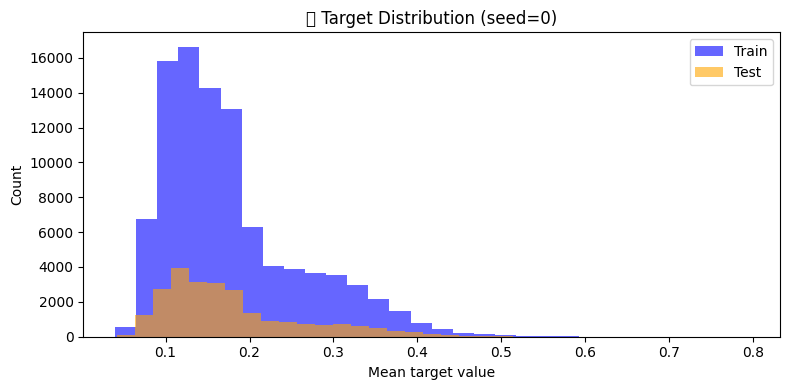

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  8.97it/s]

Epoch [10/100], Loss: 0.2115


Epochs:  21%|██        | 21/100 [00:02<00:08,  8.84it/s]

Epoch [20/100], Loss: 0.0902


Epochs:  31%|███       | 31/100 [00:03<00:08,  8.14it/s]

Epoch [30/100], Loss: 0.0218


Epochs:  41%|████      | 41/100 [00:04<00:06,  8.59it/s]

Epoch [40/100], Loss: 0.0076


Epochs:  51%|█████     | 51/100 [00:05<00:05,  9.62it/s]

Epoch [50/100], Loss: 0.0066


Epochs:  62%|██████▏   | 62/100 [00:06<00:03,  9.82it/s]

Epoch [60/100], Loss: 0.0072


Epochs:  71%|███████   | 71/100 [00:07<00:02,  9.71it/s]

Epoch [70/100], Loss: 0.0067


Epochs:  81%|████████  | 81/100 [00:08<00:01,  9.74it/s]

Epoch [80/100], Loss: 0.0062


Epochs:  91%|█████████ | 91/100 [00:09<00:00,  9.35it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.24it/s]


Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006070328410714865, 'MAE': 0.05887336656451225, 'R2': 0.12279582023620605}

🔁 Run 2 / 10 (seed = 1)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


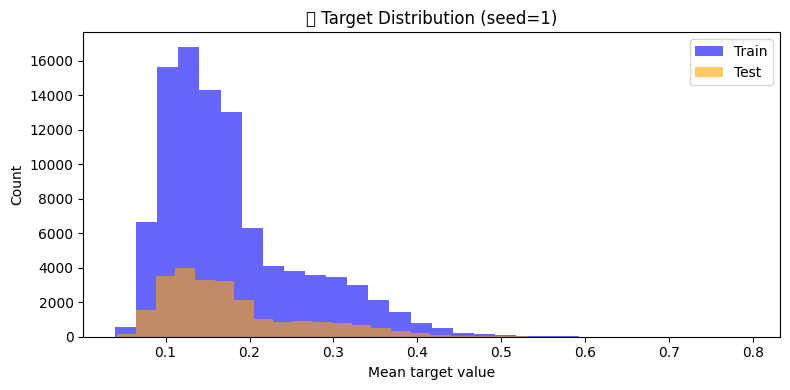

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  9.75it/s]

Epoch [10/100], Loss: 0.3450


Epochs:  21%|██        | 21/100 [00:02<00:07,  9.98it/s]

Epoch [20/100], Loss: 0.1717


Epochs:  31%|███       | 31/100 [00:05<00:23,  2.90it/s]

Epoch [30/100], Loss: 0.0647


Epochs:  41%|████      | 41/100 [00:06<00:06,  8.74it/s]

Epoch [40/100], Loss: 0.0279


Epochs:  51%|█████     | 51/100 [00:07<00:05,  9.19it/s]

Epoch [50/100], Loss: 0.0147


Epochs:  61%|██████    | 61/100 [00:08<00:04,  9.09it/s]

Epoch [60/100], Loss: 0.0094


Epochs:  71%|███████   | 71/100 [00:09<00:03,  9.06it/s]

Epoch [70/100], Loss: 0.0073


Epochs:  81%|████████  | 81/100 [00:11<00:02,  8.42it/s]

Epoch [80/100], Loss: 0.0065


Epochs:  91%|█████████ | 91/100 [00:12<00:01,  8.96it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006357856094837189, 'MAE': 0.06019372120499611, 'R2': 0.08696800470352173}

🔁 Run 3 / 10 (seed = 2)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


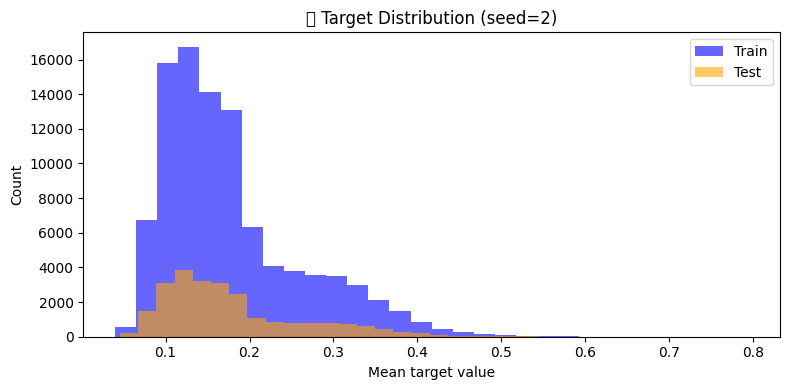

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  9.14it/s]

Epoch [10/100], Loss: 0.3204


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.69it/s]

Epoch [20/100], Loss: 0.1521


Epochs:  32%|███▏      | 32/100 [00:03<00:06, 10.15it/s]

Epoch [30/100], Loss: 0.0544


Epochs:  41%|████      | 41/100 [00:04<00:05,  9.91it/s]

Epoch [40/100], Loss: 0.0228


Epochs:  51%|█████     | 51/100 [00:05<00:04,  9.80it/s]

Epoch [50/100], Loss: 0.0111


Epochs:  62%|██████▏   | 62/100 [00:06<00:03,  9.94it/s]

Epoch [60/100], Loss: 0.0072


Epochs:  72%|███████▏  | 72/100 [00:07<00:02,  9.77it/s]

Epoch [70/100], Loss: 0.0063


Epochs:  82%|████████▏ | 82/100 [00:08<00:01,  9.89it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  92%|█████████▏| 92/100 [00:09<00:00,  9.64it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Epoch [100/100], Loss: 0.0062

📊 Metrics:
{'MSE': 0.006268527824431658, 'MAE': 0.06020090728998184, 'R2': 0.09998071193695068}

🔁 Run 4 / 10 (seed = 3)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


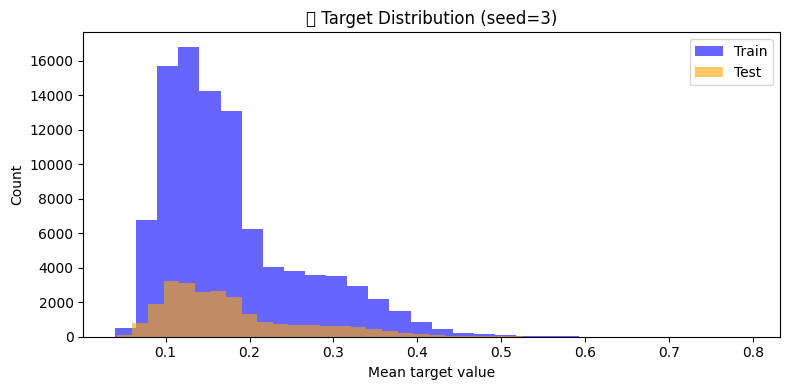

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  9.29it/s]

Epoch [10/100], Loss: 0.2582


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.43it/s]

Epoch [20/100], Loss: 0.1391


Epochs:  31%|███       | 31/100 [00:03<00:07,  9.58it/s]

Epoch [30/100], Loss: 0.0505


Epochs:  41%|████      | 41/100 [00:04<00:06,  9.20it/s]

Epoch [40/100], Loss: 0.0218


Epochs:  51%|█████     | 51/100 [00:05<00:05,  9.51it/s]

Epoch [50/100], Loss: 0.0124


Epochs:  61%|██████    | 61/100 [00:06<00:03,  9.78it/s]

Epoch [60/100], Loss: 0.0090


Epochs:  71%|███████   | 71/100 [00:07<00:02,  9.78it/s]

Epoch [70/100], Loss: 0.0074


Epochs:  81%|████████  | 81/100 [00:08<00:02,  9.04it/s]

Epoch [80/100], Loss: 0.0067


Epochs:  91%|█████████ | 91/100 [00:09<00:01,  8.12it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.45it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006263371556997299, 'MAE': 0.05992847681045532, 'R2': 0.08690100908279419}

🔁 Run 5 / 10 (seed = 4)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


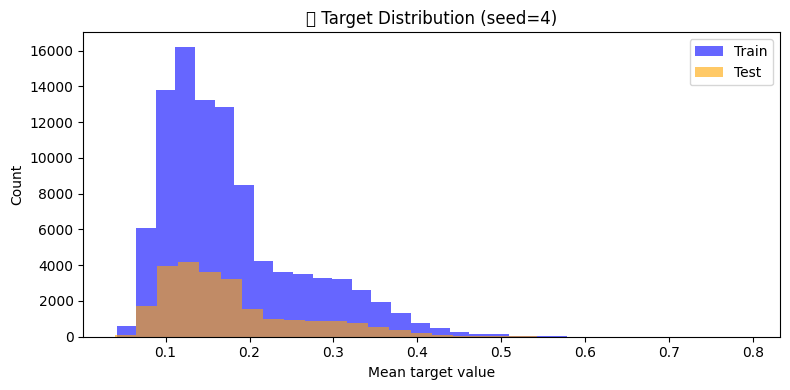

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  9.34it/s]

Epoch [10/100], Loss: 0.3236


Epochs:  21%|██        | 21/100 [00:04<00:36,  2.17it/s]

Epoch [20/100], Loss: 0.1317


Epochs:  31%|███       | 31/100 [00:05<00:08,  7.97it/s]

Epoch [30/100], Loss: 0.0415


Epochs:  41%|████      | 41/100 [00:06<00:06,  9.07it/s]

Epoch [40/100], Loss: 0.0160


Epochs:  51%|█████     | 51/100 [00:07<00:05,  9.20it/s]

Epoch [50/100], Loss: 0.0083


Epochs:  61%|██████    | 61/100 [00:09<00:04,  7.81it/s]

Epoch [60/100], Loss: 0.0066


Epochs:  71%|███████   | 71/100 [00:10<00:03,  8.15it/s]

Epoch [70/100], Loss: 0.0066


Epochs:  81%|████████  | 81/100 [00:11<00:02,  9.11it/s]

Epoch [80/100], Loss: 0.0066


Epochs:  91%|█████████ | 91/100 [00:12<00:00,  9.74it/s]

Epoch [90/100], Loss: 0.0064


Epochs: 100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006158644333481789, 'MAE': 0.06024469435214996, 'R2': 0.10610383749008179}

🔁 Run 6 / 10 (seed = 5)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


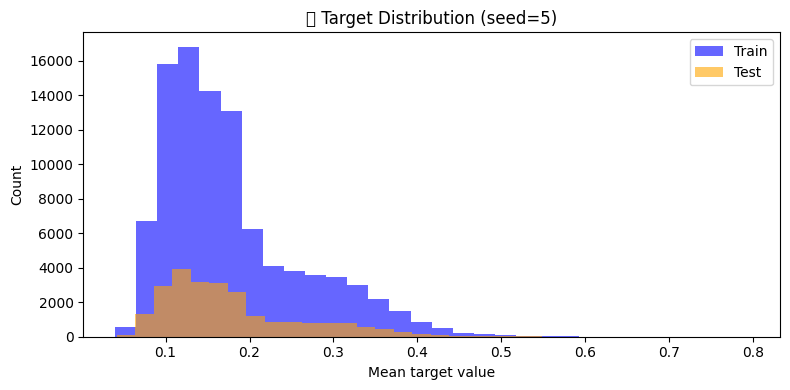

✅ Train and test are properly separated (no overlap).


Epochs:  10%|█         | 10/100 [00:00<00:09, 10.00it/s]

Epoch [10/100], Loss: 0.2558


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.67it/s]

Epoch [20/100], Loss: 0.1356


Epochs:  31%|███       | 31/100 [00:03<00:07,  9.39it/s]

Epoch [30/100], Loss: 0.0531


Epochs:  41%|████      | 41/100 [00:04<00:06,  8.59it/s]

Epoch [40/100], Loss: 0.0223


Epochs:  51%|█████     | 51/100 [00:05<00:05,  9.71it/s]

Epoch [50/100], Loss: 0.0107


Epochs:  61%|██████    | 61/100 [00:06<00:03,  9.82it/s]

Epoch [60/100], Loss: 0.0070


Epochs:  71%|███████   | 71/100 [00:07<00:03,  9.44it/s]

Epoch [70/100], Loss: 0.0066


Epochs:  81%|████████  | 81/100 [00:08<00:02,  8.11it/s]

Epoch [80/100], Loss: 0.0067


Epochs:  91%|█████████ | 91/100 [00:09<00:01,  8.68it/s]

Epoch [90/100], Loss: 0.0065


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.19it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006354021839797497, 'MAE': 0.06074889749288559, 'R2': 0.0900464653968811}

🔁 Run 7 / 10 (seed = 6)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


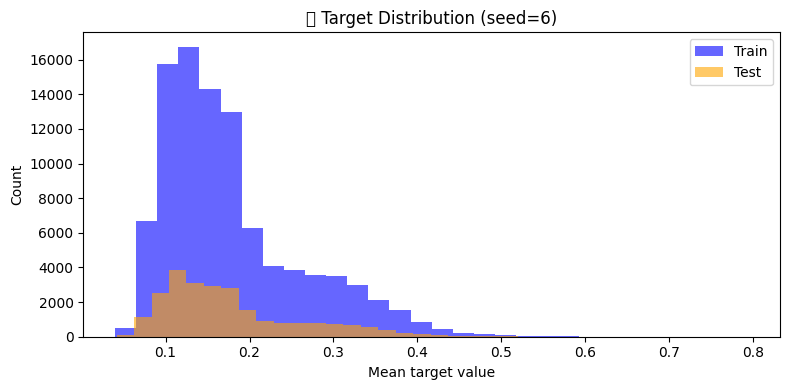

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:10,  8.13it/s]

Epoch [10/100], Loss: 0.2583


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.01it/s]

Epoch [20/100], Loss: 0.1208


Epochs:  31%|███       | 31/100 [00:03<00:08,  8.52it/s]

Epoch [30/100], Loss: 0.0362


Epochs:  41%|████      | 41/100 [00:04<00:06,  9.58it/s]

Epoch [40/100], Loss: 0.0117


Epochs:  51%|█████     | 51/100 [00:06<00:05,  9.19it/s]

Epoch [50/100], Loss: 0.0067


Epochs:  61%|██████    | 61/100 [00:07<00:04,  9.58it/s]

Epoch [60/100], Loss: 0.0071


Epochs:  71%|███████   | 71/100 [00:08<00:03,  8.99it/s]

Epoch [70/100], Loss: 0.0071


Epochs:  81%|████████  | 81/100 [00:09<00:02,  9.44it/s]

Epoch [80/100], Loss: 0.0065


Epochs:  91%|█████████ | 91/100 [00:10<00:01,  7.64it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006291541270911694, 'MAE': 0.05986277014017105, 'R2': 0.08702778816223145}

🔁 Run 8 / 10 (seed = 7)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


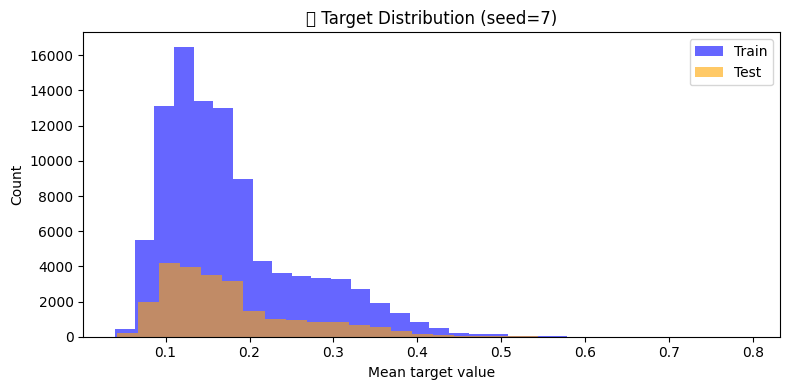

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  9.17it/s]

Epoch [10/100], Loss: 0.2858


Epochs:  21%|██        | 21/100 [00:02<00:09,  8.71it/s]

Epoch [20/100], Loss: 0.1274


Epochs:  31%|███       | 31/100 [00:03<00:07,  8.76it/s]

Epoch [30/100], Loss: 0.0426


Epochs:  41%|████      | 41/100 [00:04<00:06,  8.85it/s]

Epoch [40/100], Loss: 0.0154


Epochs:  51%|█████     | 51/100 [00:05<00:05,  8.77it/s]

Epoch [50/100], Loss: 0.0075


Epochs:  61%|██████    | 61/100 [00:06<00:04,  9.01it/s]

Epoch [60/100], Loss: 0.0066


Epochs:  71%|███████   | 71/100 [00:08<00:03,  9.27it/s]

Epoch [70/100], Loss: 0.0069


Epochs:  81%|████████  | 81/100 [00:09<00:02,  9.31it/s]

Epoch [80/100], Loss: 0.0066


Epochs:  91%|█████████ | 91/100 [00:10<00:00,  9.55it/s]

Epoch [90/100], Loss: 0.0063


Epochs: 100%|██████████| 100/100 [00:11<00:00,  9.04it/s]


Epoch [100/100], Loss: 0.0063

📊 Metrics:
{'MSE': 0.006246466189622879, 'MAE': 0.06210758909583092, 'R2': 0.08985072374343872}

🔁 Run 9 / 10 (seed = 8)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


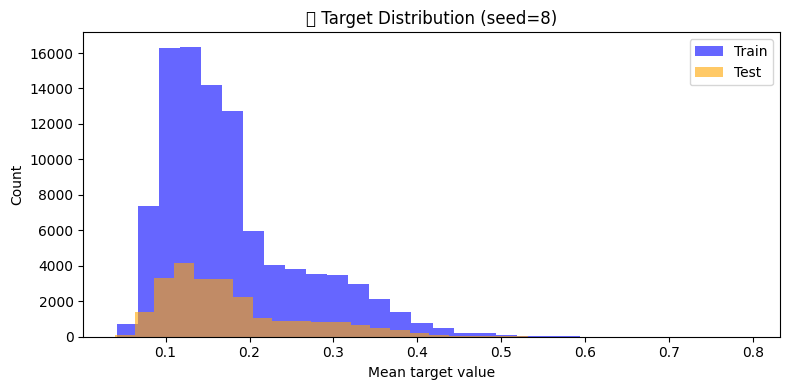

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  9.32it/s]

Epoch [10/100], Loss: 0.2777


Epochs:  21%|██        | 21/100 [00:02<00:08,  9.49it/s]

Epoch [20/100], Loss: 0.1063


Epochs:  27%|██▋       | 27/100 [00:02<00:07,  9.17it/s]


⏹️ Early stopping at epoch 28

📊 Metrics:
{'MSE': 0.041242942214012146, 'MAE': 0.18790701031684875, 'R2': -4.9054131507873535}

🔁 Run 10 / 10 (seed = 9)
Dataset loaded: 121113 rows, 15 columns


/tmp/ipykernel_14923/2611593070.py:32: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_fluctuation_prediction_2025/environment/linux_wfp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


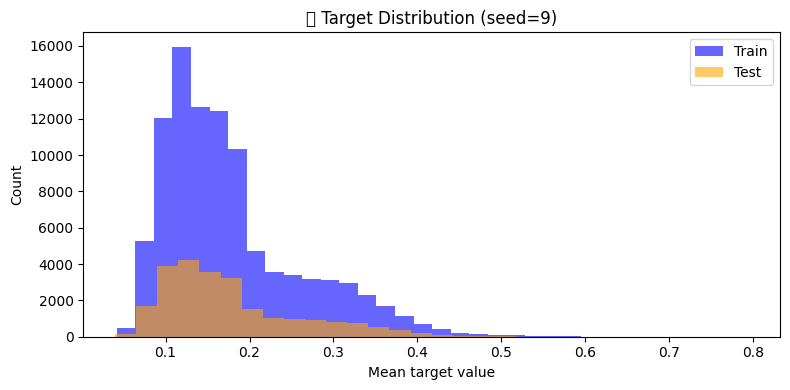

✅ Train and test are properly separated (no overlap).


Epochs:  11%|█         | 11/100 [00:01<00:09,  9.44it/s]

Epoch [10/100], Loss: 0.2242


Epochs:  22%|██▏       | 22/100 [00:02<00:08,  9.39it/s]

Epoch [20/100], Loss: 0.0902


Epochs:  31%|███       | 31/100 [00:03<00:07,  9.32it/s]

Epoch [30/100], Loss: 0.0238


Epochs:  41%|████      | 41/100 [00:04<00:06,  9.26it/s]

Epoch [40/100], Loss: 0.0083


Epochs:  51%|█████     | 51/100 [00:05<00:05,  9.64it/s]

Epoch [50/100], Loss: 0.0066


Epochs:  61%|██████    | 61/100 [00:06<00:04,  9.51it/s]

Epoch [60/100], Loss: 0.0072


Epochs:  71%|███████   | 71/100 [00:07<00:03,  9.63it/s]

Epoch [70/100], Loss: 0.0068


Epochs:  81%|████████  | 81/100 [00:08<00:02,  9.04it/s]

Epoch [80/100], Loss: 0.0063


Epochs:  91%|█████████ | 91/100 [00:09<00:01,  8.45it/s]

Epoch [90/100], Loss: 0.0062


Epochs: 100%|██████████| 100/100 [00:10<00:00,  9.18it/s]

Epoch [100/100], Loss: 0.0061

📊 Metrics:
{'MSE': 0.006128726527094841, 'MAE': 0.05900295078754425, 'R2': 0.11392182111740112}
📁 Best weights saved to: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_003/best_model_weights_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.pt
🏆 Best run: run_seed_0 with R2 = 0.1228
   R2   = 0.1228
   MAE  = 0.0589
   MSE  = 0.006070


In [61]:
# 📁 src/tuning/run_experiments.py
# ➤ Run MLP training multiple times with different random seeds to assess stability
# ➤ Track and save best model based on R² score
# ➤ Store metrics for each run, save best weights and evaluation report


# 🧠 Prepare model
# 📌 Fixed parameters
EPOCHS = 100
OUTPUT_DIM = 1
N_RUNS = 10  # Total number of runs

# 📊 Containers to collect results
results_all = []
results_header = ["run", "run_id", "R2", "MAE", "MSE"]
best_r2 = -float("inf")
best_model = None
best_metrics = None
best_run_id = None
train_loss_history = [] 
weights_registry = {}  # run_id -> weights
weights_registry.clear()


# 🔁 Run the same config with different random seeds
for seed in range(N_RUNS):
    print(f"\n🔁 Run {seed + 1} / {N_RUNS} (seed = {seed})")

    # 🏃 Train model with current seed
    run_id, metrics = train_mlp(
        hidden_dim=config["hidden_dim"],
        lr=config["lr"],
        batch_size=config["batch_size"],
        epochs=EPOCHS,
        output_dim=config["output_dim"],
        activation_fn=config["activation_fn"],
        optimizer_name=config["optimizer_name"],
        seed=seed
    )

    # 📥 Collect result for this run
    results_all.append({
        "run": seed,
        "run_id": run_id,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    # 🏆 Check if it's the best so far
    if metrics["R2"] > best_r2:
        best_r2 = metrics["R2"]
        best_metrics = metrics
        best_run_id = run_id

# 💾 Save best model weights
best_weights = weights_registry[best_run_id]
weights_save_path = os.path.join(SAVE_ROOT, f"best_model_weights_{arch_label}.pt")
torch.save(best_weights, weights_save_path)
print(f"📁 Best weights saved to: {weights_save_path}")

# 💾 Save full metrics log
results_csv_path = os.path.join(SAVE_ROOT, f"results_{arch_label}.csv")
df_results = pd.DataFrame(results_all, columns=results_header)
df_results.to_csv(results_csv_path, index=False)

# 💾 Save best run's metrics
metrics_json_path = os.path.join(SAVE_ROOT, f"metrics_best_{arch_label}.json")
with open(metrics_json_path, "w") as f:
    json.dump(best_metrics, f, indent=4)

print(f"🏆 Best run: {best_run_id} with R2 = {best_r2:.4f}")
print(f"   R2   = {best_metrics['R2']:.4f}")
print(f"   MAE  = {best_metrics['MAE']:.4f}")
print(f"   MSE  = {best_metrics['MSE']:.6f}")


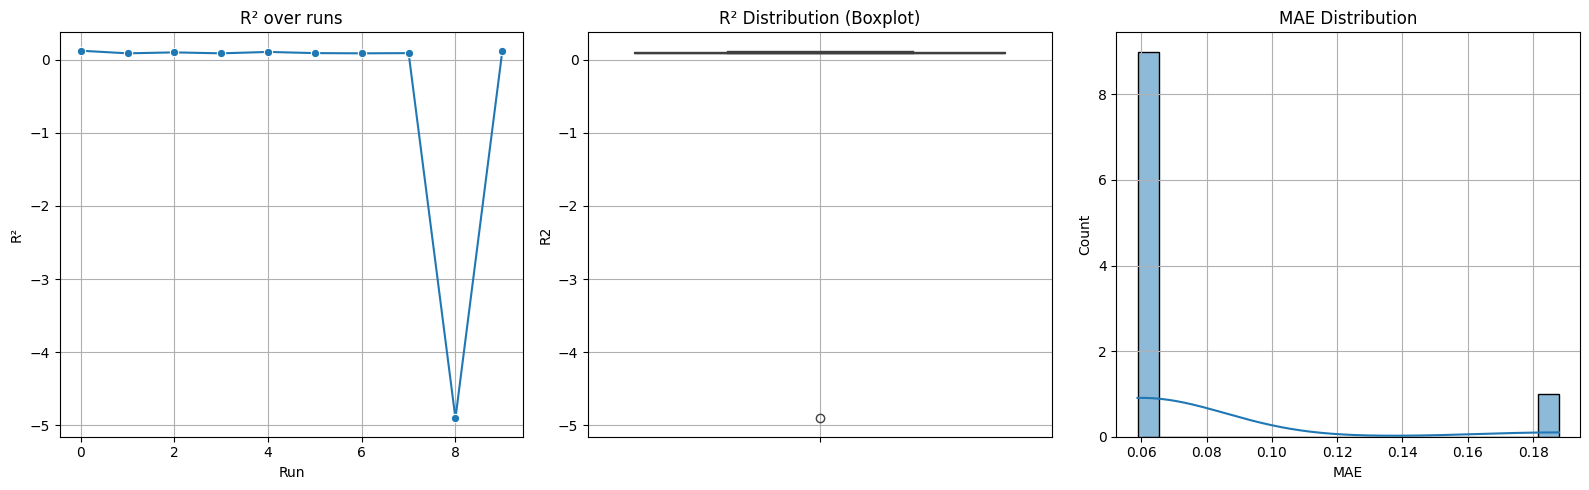

📈 Stability analysis complete:
{
    "R2_mean": -0.4022,
    "R2_std": 1.5823,
    "MAE_mean": 0.0729,
    "MAE_std": 0.0404,
    "MSE_mean": 0.009738,
    "MSE_std": 0.01107,
    "runs": 10
}
📁 Saved metrics: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_003/stability_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.json
🖼️  Saved plot: /mnt/d/projects/wind_fluctuation_prediction_2025/final_models/config_003/stability_plot_mlp_128h_4e-03lr_16bs_10000ep_Tanh_Adam.png


In [62]:
# 📁 src/tuning/analyze_stability.py
# ➤ Analyze stability of model performance across multiple seeds
# ➤ Compute mean and std for R², MAE, MSE
# ➤ Generate and save visualizations (line plot, boxplot, histogram)
# ➤ Save stability metrics to JSON for reporting and comparison


# 📥 Load results
df = pd.read_csv(results_csv_path)

# 📊 Compute stability stats
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Save stability metrics
stability_path = os.path.join(SAVE_ROOT, f"stability_{arch_label}.json")
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Visualization
plt.figure(figsize=(16, 5))

# 📌 Plot 1: R² over runs
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("R² over runs")
plt.xlabel("Run")
plt.ylabel("R²")
plt.grid(True)

# 📌 Plot 2: Boxplot of R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("R² Distribution (Boxplot)")
plt.grid(True)

# 📌 Plot 3: Histogram of MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Save the plot
fig_path = os.path.join(SAVE_ROOT, f"stability_plot_{arch_label}.png")
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Output
print("📈 Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")
